In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys
sys.path.append('/content/drive/MyDrive/CFA-CFA_MC')

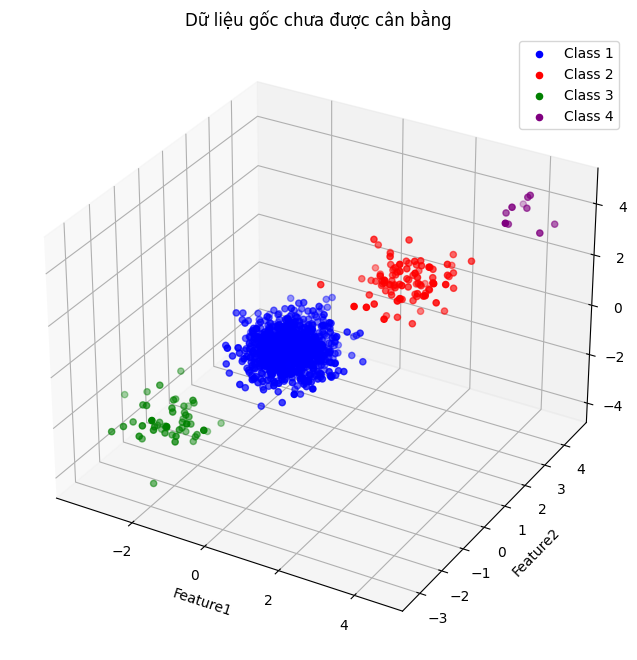

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from cfa import CFA

# Số lượng mẫu cho mỗi lớp
n_1 = 1000  # Lớp đa số
n_2 = 100 #Lớp thiểu số
n_3 = 50 #Lớp thiểu số
n_4 = 10    # Lớp thiểu số

# Tham số cho mỗi lớp
mean_class1 = [0, 0, 0]
std_class1 = [0.5, 0.5, 0.5]

mean_class2 = [2, 2, 2]
std_class2 = [0.5, 0.5, 0.5]

mean_class3 = [-2, -2, -2]
std_class3 = [0.5, 0.5, 0.5]

mean_class4 = [4, 4, 4]
std_class4 = [0.5, 0.5, 0.5]

# Tạo dữ liệu
data_class1 = np.random.normal(loc=mean_class1, scale=std_class1, size=(n_1, 3))
data_class2 = np.random.normal(loc=mean_class2, scale=std_class2, size=(n_2, 3))
data_class3 = np.random.normal(loc=mean_class3, scale=std_class3, size=(n_3, 3))
data_class4 = np.random.normal(loc=mean_class4, scale=std_class4, size=(n_4, 3))

# Tạo DataFrame và thêm nhãn lớp
df_class1 = pd.DataFrame(data_class1, columns=['Feature1', 'Feature2', 'Feature3'])
df_class1['Class'] = 1
df_class2 = pd.DataFrame(data_class2, columns=['Feature1', 'Feature2', 'Feature3'])
df_class2['Class'] = 2
df_class3 = pd.DataFrame(data_class3, columns=['Feature1', 'Feature2', 'Feature3'])
df_class3['Class'] = 3
df_class4 = pd.DataFrame(data_class4, columns=['Feature1', 'Feature2', 'Feature3'])
df_class4['Class'] = 4

df = pd.concat([df_class1, df_class2, df_class3, df_class4], ignore_index=True)

# Xáo trộn DataFrame
df = df.sample(frac=1).reset_index(drop=True)

# Hàm trực quan hóa
def plot_3d_data(df, title):
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    colors = ['blue', 'red', 'green', 'purple']
    for i, color in enumerate(colors, 1):
        class_data = df[df['Class'] == i]
        ax.scatter(class_data['Feature1'], class_data['Feature2'], class_data['Feature3'],
                   c=color, label=f'Class {i}')

    ax.set_xlabel('Feature1')
    ax.set_ylabel('Feature2')
    ax.set_zlabel('Feature3')
    ax.set_title(title)
    ax.legend()
    plt.show()

# Vẽ dữ liệu gốc
plot_3d_data(df, 'Dữ liệu gốc chưa được cân bằng')

In [5]:
# Hàm để áp dụng CFA và tạo mẫu tổng hợp
def apply_cfa(X, y, minority_class, tol, fd):
    cfa = CFA(fd=fd, tol=tol)
    mask = (y == 1) | (y == minority_class)
    X_subset = X[mask]
    y_subset = y[mask]
    synthetic_X, synthetic_y, synthetic_labels = cfa.run_cfa(X_subset, y_subset, get_synt_labels=True)
    return synthetic_X[synthetic_labels == 1], synthetic_y[synthetic_labels == 1]

# Hàm để cân bằng dữ liệu và in kết quả
def balance_and_print(X, y, tol, fd):
    synthetic_samples = []
    for minority_class in [2, 3, 4]:
        synth_X, synth_y = apply_cfa(X, y, minority_class, tol, fd)
        synthetic_samples.append(pd.DataFrame(synth_X, columns=['Feature1', 'Feature2', 'Feature3']))
        synthetic_samples[-1]['Class'] = synth_y

    synthetic_df = pd.concat(synthetic_samples, ignore_index=True)
    synthetic_df['Synthetic'] = 1

    balanced_df = pd.concat([df, synthetic_df], ignore_index=True)

    print(f"\nResults for tol={tol}, fd={fd}:")
    print("Số mẫu từng lớp sau khi cân bằng:")
    print(balanced_df['Class'].value_counts())

    for i in range(1, 5):
        synthetic_count = np.sum((balanced_df['Class'] == i) & (balanced_df['Synthetic'] == 1))
        print(f"Number of synthetic samples for Class {i}: {synthetic_count}")

    return balanced_df

# Dữ liệu gốc
X = df[['Feature1', 'Feature2', 'Feature3']].values
y = df['Class'].values

print("Số mẫu từng lớp trước khi cân bằng:")
print(df['Class'].value_counts())

Số mẫu từng lớp trước khi cân bằng:
Class
1    1000
2     100
3      50
4      10
Name: count, dtype: int64


No synthetic instance generated
Please try to increase the tolerance level or decrease the feature diff

Results for tol=1.0, fd=1:
Số mẫu từng lớp sau khi cân bằng:
Class
1    1000
2     253
3     143
4      10
Name: count, dtype: int64
Number of synthetic samples for Class 1: 0
Number of synthetic samples for Class 2: 153
Number of synthetic samples for Class 3: 93
Number of synthetic samples for Class 4: 0
No synthetic instance generated
Please try to increase the tolerance level or decrease the feature diff

Results for tol=1.5, fd=1:
Số mẫu từng lớp sau khi cân bằng:
Class
1    1000
3     776
2     676
4      10
Name: count, dtype: int64
Number of synthetic samples for Class 1: 0
Number of synthetic samples for Class 2: 576
Number of synthetic samples for Class 3: 726
Number of synthetic samples for Class 4: 0
No synthetic instance generated
Please try to increase the tolerance level or decrease the feature diff

Results for tol=2.0, fd=1:
Số mẫu từng lớp sau khi cân bằng:
Class
1

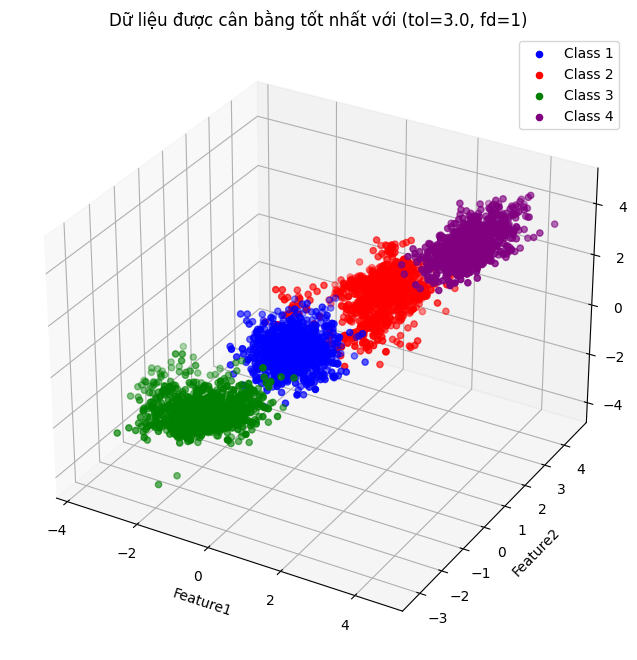

In [6]:
# Kiểm thử với nhiều giá trị dung sai và số lượng trích suất đặc trưng tol và fd
tol_values = [1.0, 1.5, 2.0, 2.5, 3.0]
fd_values = [1, 2]

best_balanced_df = None
best_tol = None
best_fd = None
best_min_synthetic = 0

for fd in fd_values:
    for tol in tol_values:
        balanced_df = balance_and_print(X, y, tol, fd)
        min_synthetic = min([np.sum((balanced_df['Class'] == i) & (balanced_df['Synthetic'] == 1)) for i in [2, 3, 4]])

        if min_synthetic > best_min_synthetic:
            best_min_synthetic = min_synthetic
            best_balanced_df = balanced_df
            best_tol = tol
            best_fd = fd

print(f"\n Kết quả tốt nhất với tol={best_tol}, fd={best_fd}")

# Vẽ lại biểu đồ phân phối dữ liệu
plot_3d_data(best_balanced_df, f'Dữ liệu được cân bằng tốt nhất với (tol={best_tol}, fd={best_fd})')

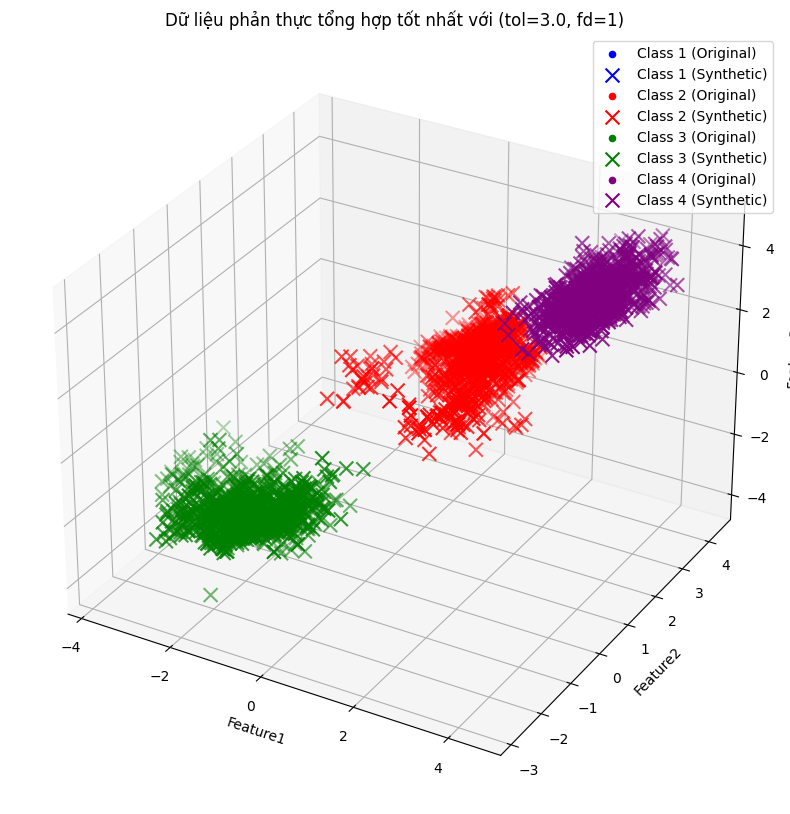

In [12]:
# Vẽ lại biểu đồ phân phối dữ liệu synthetic tốt nhất
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111, projection='3d')

colors = ['blue', 'red', 'green', 'purple']
for i, color in enumerate(colors, 1):
    class_data = best_balanced_df[(best_balanced_df['Class'] == i) & (best_balanced_df['Synthetic'] == 0)]
    ax.scatter(class_data['Feature1'], class_data['Feature2'], class_data['Feature3'],
               c=color, label=f'Class {i} (Original)')

    synthetic_data = best_balanced_df[(best_balanced_df['Class'] == i) & (best_balanced_df['Synthetic'] == 1)]
    ax.scatter(synthetic_data['Feature1'], synthetic_data['Feature2'], synthetic_data['Feature3'],
               c=color, marker='x', s=100, label=f'Class {i} (Synthetic)')

ax.set_xlabel('Feature1')
ax.set_ylabel('Feature2')
ax.set_zlabel('Feature3')
ax.set_title(f'Dữ liệu phản thực tổng hợp tốt nhất với (tol={best_tol}, fd={best_fd})')
ax.legend()
plt.show()

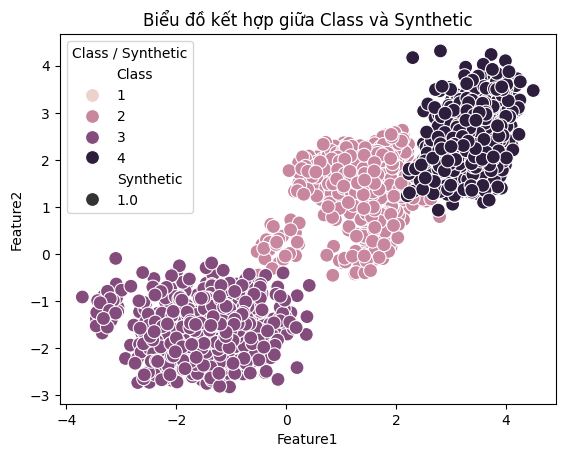

In [13]:
import seaborn as sns

# Vẽ biểu đồ kết hợp giữa Class và Synthetic
sns.scatterplot(x='Feature1', y='Feature2', hue='Class', style='Synthetic', data=best_balanced_df, s=100)
plt.title('Biểu đồ kết hợp giữa Class và Synthetic')
plt.xlabel('Feature1')
plt.ylabel('Feature2')
plt.legend(title='Class / Synthetic')
plt.show()

<ipython-input-14-54dfd7511cb7>:4: UserWarning: The markers list has more values (2) than needed (1), which may not be intended.
  sns.scatterplot(x='Feature1', y='Feature2', hue='Class', style='Synthetic', data=best_balanced_df, s=100,


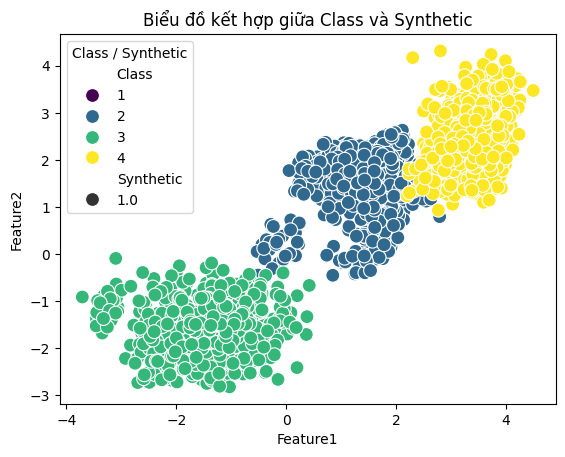

In [14]:
import seaborn as sns

# Vẽ lại biểu đồ seaborn với từng Synthetic khác màu
sns.scatterplot(x='Feature1', y='Feature2', hue='Class', style='Synthetic', data=best_balanced_df, s=100,
                palette='viridis', markers=['o', 'x'])
plt.title('Biểu đồ kết hợp giữa Class và Synthetic')
plt.xlabel('Feature1')
plt.ylabel('Feature2')
plt.legend(title='Class / Synthetic')
plt.show()

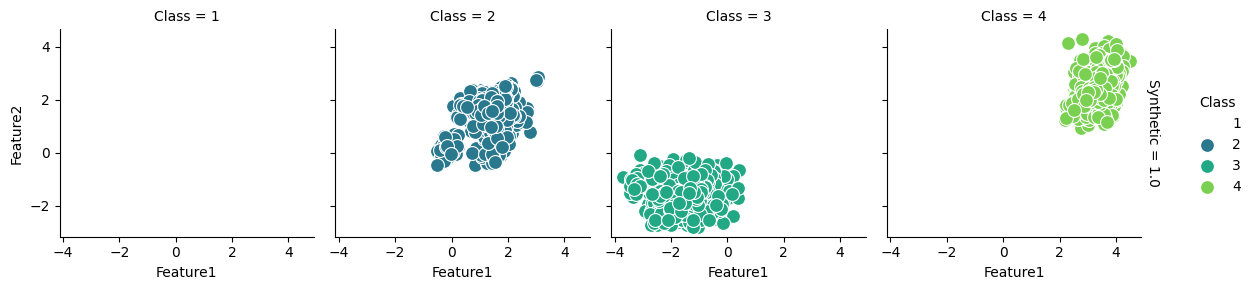

In [15]:
import seaborn as sns

# Vẽ biểu đồ riêng cho từng Class và Synthetic
g = sns.FacetGrid(best_balanced_df, col='Class', row='Synthetic', hue='Class',
                  palette='viridis', margin_titles=True)
g.map(sns.scatterplot, 'Feature1', 'Feature2', s=100)
g.add_legend(title='Class')
plt.show()

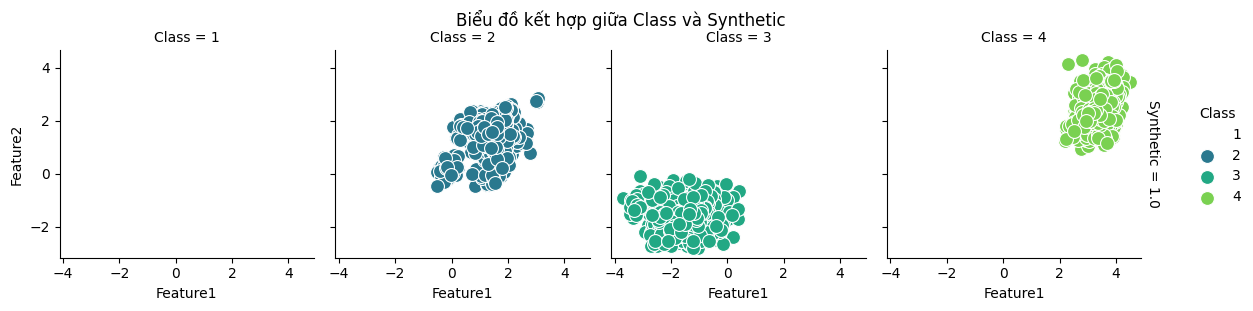

In [16]:
import seaborn as sns

# Vẽ biểu đồ riêng cho từng Class và Synthetic
g = sns.FacetGrid(best_balanced_df, col='Class', row='Synthetic', hue='Class',
                  palette='viridis', margin_titles=True)
g.map(sns.scatterplot, 'Feature1', 'Feature2', s=100)
g.add_legend(title='Class')

# Thêm tiêu đề cho biểu đồ
g.fig.suptitle('Biểu đồ kết hợp giữa Class và Synthetic', y=1.02)

plt.show()

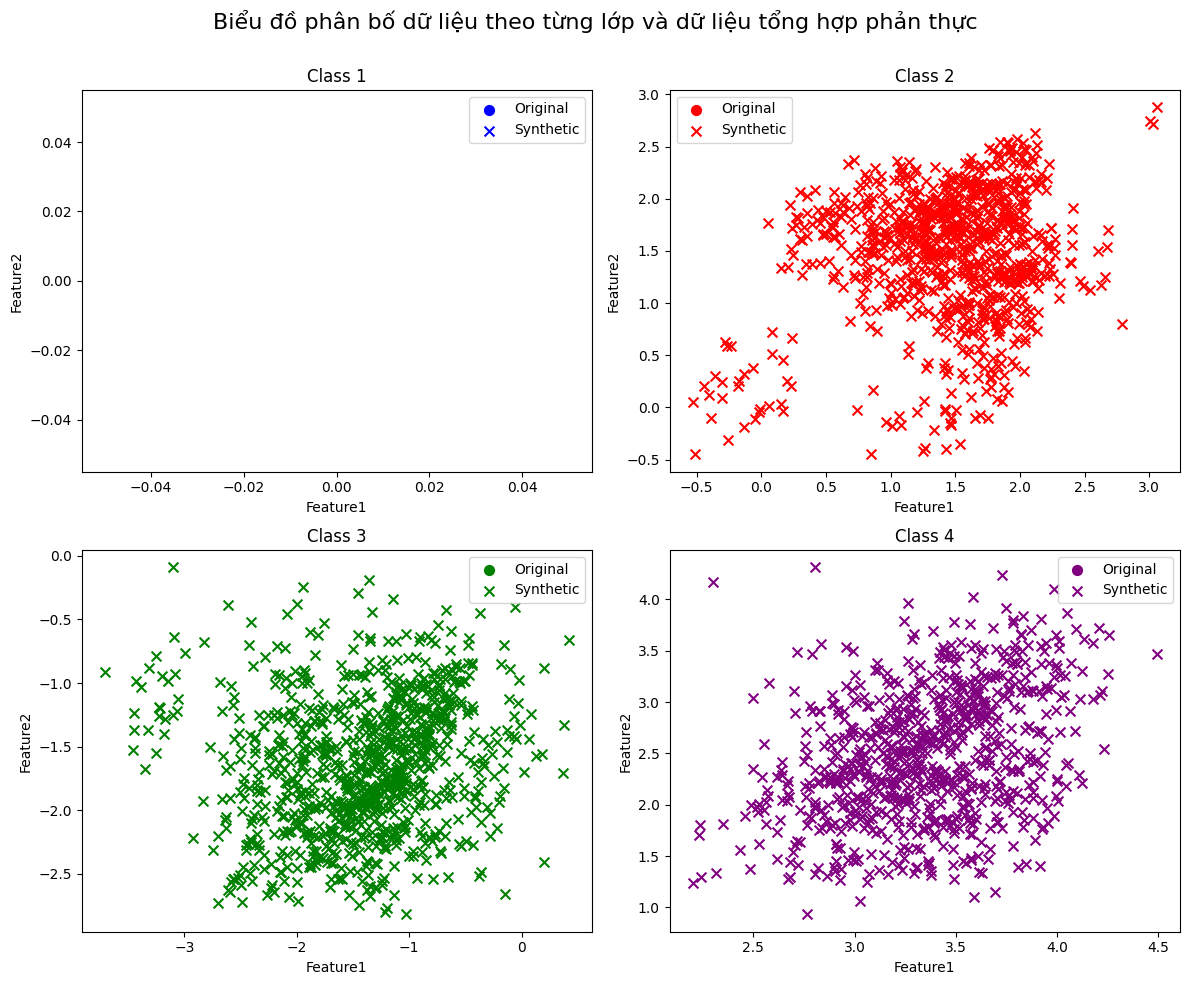

In [18]:
import matplotlib.pyplot as plt

# Vẽ biểu đồ riêng cho từng class
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Biểu đồ phân bố dữ liệu theo từng lớp và dữ liệu tổng hợp phản thực', fontsize=16)

colors = ['blue', 'red', 'green', 'purple']
markers = ['o', 'x']

for i, ax in enumerate(axes.flat, start=1):
    class_data = best_balanced_df[best_balanced_df['Class'] == i]

    # Vẽ điểm dữ liệu gốc
    original_data = class_data[class_data['Synthetic'] == 0]
    ax.scatter(original_data['Feature1'], original_data['Feature2'],
               c=colors[i-1], marker=markers[0], label='Original', s=50)

    # Vẽ điểm tổng hợp
    synthetic_data = class_data[class_data['Synthetic'] == 1]
    ax.scatter(synthetic_data['Feature1'], synthetic_data['Feature2'],
               c=colors[i-1], marker=markers[1], label='Synthetic', s=50)

    ax.set_title(f'Class {i}')
    ax.set_xlabel('Feature1')
    ax.set_ylabel('Feature2')
    ax.legend()

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

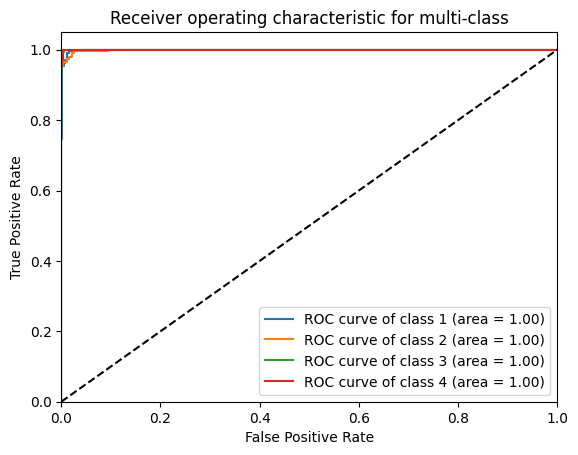

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc

# Dữ liệu đã được cân bằng (best_balanced_df)
# ... (Đoạn mã tạo best_balanced_df từ câu hỏi trước)

# Chuẩn bị dữ liệu
X = best_balanced_df[['Feature1', 'Feature2', 'Feature3']]
y = best_balanced_df['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Huấn luyện mô hình phân loại (Logistic Regression)
model = LogisticRegression()
model.fit(X_train, y_train)

# Tính toán xác suất dự đoán
y_probs = model.predict_proba(X_test)

# Vẽ biểu đồ ROC
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y.nunique()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test == i + 1, y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                   ''.format(i + 1, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Đường cong ROC cho đa lớp')
plt.legend(loc="lower right")
plt.show()

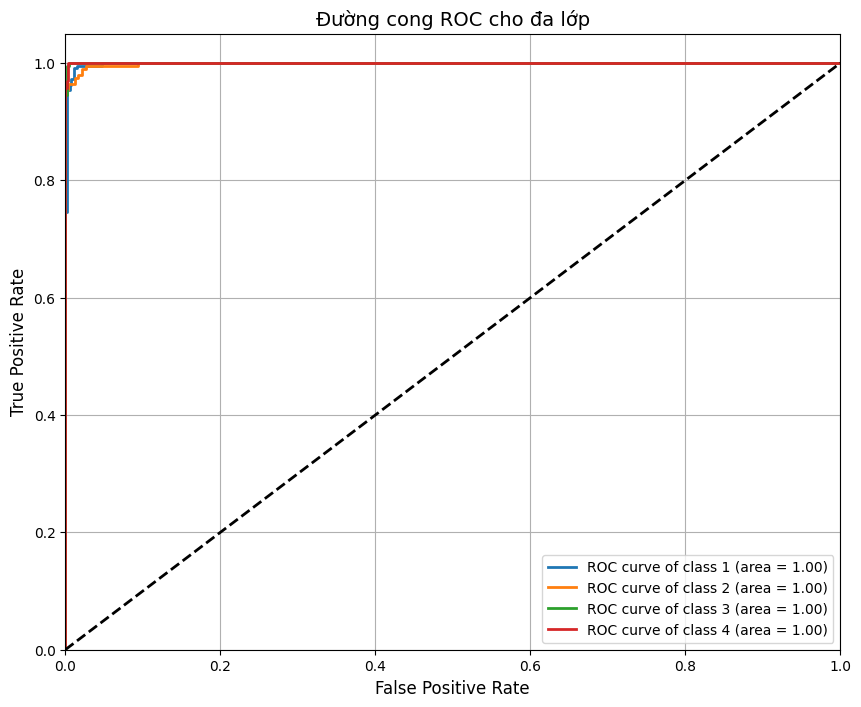

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc

# Dữ liệu đã được cân bằng (best_balanced_df)
# ... (Đoạn mã tạo best_balanced_df từ câu hỏi trước)

# Chuẩn bị dữ liệu
X = best_balanced_df[['Feature1', 'Feature2', 'Feature3']]
y = best_balanced_df['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Huấn luyện mô hình phân loại (Logistic Regression)
model = LogisticRegression()
model.fit(X_train, y_train)

# Tính toán xác suất dự đoán
y_probs = model.predict_proba(X_test)

# Vẽ biểu đồ ROC
plt.figure(figsize=(10, 8))  # Tăng kích thước biểu đồ
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y.nunique()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test == i + 1, y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Vẽ biểu đồ ROC cho từng lớp với độ dày đường cong lớn hơn
linewidth = 2
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=linewidth, label='ROC curve of class {0} (area = {1:0.2f})'
                                   ''.format(i + 1, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=linewidth)  # Tăng độ dày đường chéo
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)  # Tăng kích thước font chữ
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Đường cong ROC cho đa lớp', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True)  # Thêm lưới
plt.show()

<ipython-input-22-2001333a39f0>:69: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(methods, rotation='vertical')


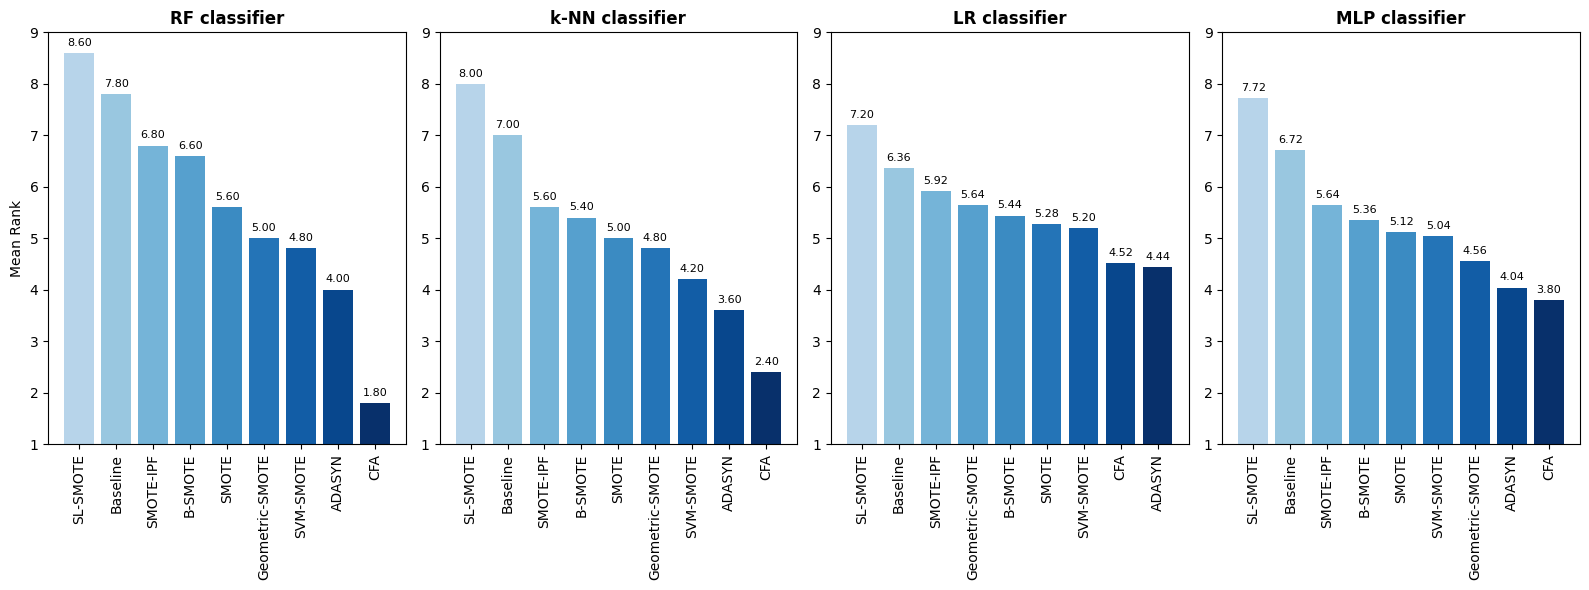

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Dữ liệu Mean Rank được tính toán dựa trên 5 tập dữ liệu
data = {
    'RF classifier': {
        'CFA': 1.80,
        'ADASYN': 4.00,
        'SVM-SMOTE': 4.80,
        'Geometric-SMOTE': 5.00,
        'SMOTE': 5.60,
        'B-SMOTE': 6.60,
        'SMOTE-IPF': 6.80,
        'Baseline': 7.80,
        'SL-SMOTE': 8.60,
    },
    'k-NN classifier': {
        'CFA': 2.40,
        'ADASYN': 3.60,
        'SVM-SMOTE': 4.20,
        'Geometric-SMOTE': 4.80,
        'SMOTE': 5.00,
        'B-SMOTE': 5.40,
        'SMOTE-IPF': 5.60,
        'Baseline': 7.00,
        'SL-SMOTE': 8.00,
    },
    'LR classifier': {
        'CFA': 4.52,
        'ADASYN': 4.44,
        'SVM-SMOTE': 5.20,
        'Geometric-SMOTE': 5.64,
        'SMOTE': 5.28,
        'B-SMOTE': 5.44,
        'SMOTE-IPF': 5.92,
        'Baseline': 6.36,
        'SL-SMOTE': 7.20,
    },
    'MLP classifier': {
        'CFA': 3.80,
        'ADASYN': 4.04,
        'SVM-SMOTE': 5.04,
        'Geometric-SMOTE': 4.56,
        'SMOTE': 5.12,
        'B-SMOTE': 5.36,
        'SMOTE-IPF': 5.64,
        'Baseline': 6.72,
        'SL-SMOTE': 7.72,
    },
}

# Tạo màu sắc cho các cột
colors = plt.cm.Blues(np.linspace(0.3, 1, len(data['RF classifier'])))

# Vẽ biểu đồ cho mỗi bộ phân loại
fig, axes = plt.subplots(1, 4, figsize=(16, 6))

for i, (classifier, values) in enumerate(data.items()):
    # Sắp xếp dữ liệu theo thứ tự giảm dần của mean rank
    sorted_values = dict(sorted(values.items(), key=lambda item: item[1], reverse=True))
    methods = list(sorted_values.keys())
    mean_ranks = list(sorted_values.values())

    axes[i].bar(methods, mean_ranks, color=colors)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Mean Rank' if i == 0 else '')
    axes[i].set_title(classifier, fontweight='bold')
    axes[i].set_ylim(1, 9)  # Giới hạn trục y từ 1 đến 9
    axes[i].set_xticklabels(methods, rotation='vertical')

    # Hiển thị giá trị mean rank trên mỗi cột
    for j, v in enumerate(mean_ranks):
        axes[i].text(j, v + 0.1, f'{v:.2f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()